In [106]:
import numpy as np
import pandas as pd

from scipy import spatial, stats, cluster
import matplotlib.pyplot as plt
import seaborn as sns
import nibabel as nib
from nilearn import plotting, input_data
from nilearn.datasets import fetch_atlas_schaefer_2018

import networkx as nx

import matplotlib.cm as mplcm
import matplotlib.colors as colors
import bct
import glob
import community as community_louvain
import matplotlib.cm as cm
from sklearn.metrics import adjusted_rand_score
import os
import random


%matplotlib inline

# Styles
sns.set_context('poster')
sns.set_style('darkgrid')

plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower


In [107]:
dfLabels = pd.read_csv("../resources/aal_extended.csv",header=None) 
dfLabels.columns = ['reindex','name','mark','region','side']
dfLabels["region_side"] = dfLabels["region"] + "_" + dfLabels["side"]

print(dfLabels.head())

labels = dfLabels['name'].values

   reindex               name  mark   region side region_side
0        1       Precentral_L  2001  Central    L   Central_L
1        2       Precentral_R  2002  Central    R   Central_R
2        3      Frontal_Sup_L  2101  Frontal    L   Frontal_L
3        4      Frontal_Sup_R  2102  Frontal    R   Frontal_R
4        5  Frontal_Sup_Orb_L  2111  Frontal    L   Frontal_L


In [111]:
filename = '../resources/DataSujetos/N1_suj1.csv'
df = pd.read_csv(filename, header=None)
df -= np.diag(np.ones(n))
n = df.shape[0]
aristas_posibles= (n*n-n)//2
aristas_posibles*0.15 #Busco cantidad tal que densidad sea 0.15

ds = np.arange(150,2200//2,50)
#ds.max()/aristas_posibles
ds/aristas_posibles

TypeError: type numpy.ndarray doesn't define __round__ method

In [208]:

#threshold = 0.4

densities = 0.15

df_barrido = pd.DataFrame()


for edges_density in ds:#np.round(np.linspace(0.02,0.16,20,endpoint=False),4):
    
    print(edges_density)

    Rand = {"edges_density":[],
                "N1_mean":[],
                 "N2_mean":[],
                 "N3_mean":[],
                 "W_mean":[],
                 "N1_std":[],
                 "N2_std":[],
                 "N3_std":[],
                 "W_std":[],
                 }

    tipo_red="W"
    sleep_states = ['N1','N2','N3']

    path = r'../resources/DataSujetos' # use your path
    all_files = glob.glob(path + f"/{tipo_red}_suj*.csv")

    dict_rand = {}

    values_obs_dict = {}

    values_per_dict = {}

    lists_rand = {}
    for sleep_state in sleep_states:
        lists_rand[sleep_state] = []
    lists_rand["W"] = []

    for filename_W in all_files:
        #print(filename_W)

        df = pd.read_csv(filename_W, header=None, index_col=None,)
        df -= np.diag(np.ones(n))
        
        
#         n = correlation_matrix.shape[0]
#         correlation_matrix -= np.diag(np.ones(n))
#         max_links = (n*n-n)//2
#         tril_idx = np.tril_indices(n,-1)
#         sorted_correlations = sorted(correlation_matrix.values[tril_idx].flatten(),reverse=True)
#         idx = int(edges_density*max_links)
#         threshold = sorted_correlations[idx]
#         #Gs.append(nx.from_pandas_adjacency(correlation_matrix>=threshold))
        
        sort_corrs = sorted(df.values.flatten(),reverse=True)
        threshold = sort_corrs[edges_density]
        thresh_cmat = (df.values >= threshold) * 1.0
        GW = nx.from_numpy_matrix(thresh_cmat)
        
        label_data = pd.DataFrame({'number': np.arange(len(labels)) + 1, 'region_side': labels})
        GW = nx.relabel_nodes(GW, lambda x: label_data['number'].tolist()[x])

        modulos = community_louvain.best_partition(GW)
        #print({"umbral":round(threshold,2), "clusters": len(set(modulos.values()))})
        values_obs = [v for n,v in modulos.items()]
        values_obs_dict[filename_W] = values_obs

        #print({filename_W: set(values_obs)})
        rand_score = adjusted_rand_score(values_obs, values_obs)
        lists_rand["W"].append(rand_score)


        for sleep_state in sleep_states:
            filename_Nx = filename_W.replace("W_", sleep_state+"_")

            df = pd.read_csv(filename_Nx, header=None, index_col=None,)
            df -= np.diag(np.ones(n))
            sort_corrs = sorted(df.values.flatten(),reverse=True)
            threshold = sort_corrs[edges_density]
            thresh_cmat = (df.values >= threshold) * 1.0
            GNx = nx.from_numpy_matrix(thresh_cmat)
            label_data = pd.DataFrame({'number': np.arange(len(labels)) + 1, 'region_side': labels})
            GNx = nx.relabel_nodes(GNx, lambda x: label_data['number'].tolist()[x])

            modulos = community_louvain.best_partition(GNx)
            values_per = [v for n,v in modulos.items()]
            values_per_dict[filename_Nx] = values_per
            #print({filename_W: set(values_obs)})

            #print({os.path.basename(filename_Nx):adjusted_rand_score(values_obs, values_per)})

            rand_score = adjusted_rand_score(values_obs, values_per)

            dict_rand[os.path.basename(filename_Nx)] = rand_score

            lists_rand[sleep_state].append(rand_score)

        #break
    df_real = pd.DataFrame(lists_rand)
    df_real_desc = df_real.describe()

    Rand["edges_density"].append(edges_density/aristas_posibles)
    Rand["N1_mean"].append(df_real_desc['N1']['mean'])
    Rand["N2_mean"].append(df_real_desc['N2']['mean'])
    Rand["N3_mean"].append(df_real_desc['N3']['mean'])
    Rand["W_mean"].append(df_real_desc['W']['mean'])
    Rand["N1_std"].append(df_real_desc['N1']['std'])
    Rand["N2_std"].append(df_real_desc['N2']['std'])
    Rand["N3_std"].append(df_real_desc['N3']['std'])
    Rand["W_std"].append(df_real_desc['W']['std'])

    df_rand_real = pd.DataFrame(Rand)
    #print(df_rand_real)
    
    df_barrido = df_barrido.append(df_rand_real, ignore_index=True)
    
df_barrido

150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050


,edges_density,N1_mean,N2_mean,N3_mean,W_mean,N1_std,N2_std,N3_std,W_std
0,0.022489,0.480788,0.431518,0.375238,1.0,0.116142,0.070427,0.110468,0.0
1,0.029985,0.476978,0.432714,0.375087,1.0,0.159985,0.096944,0.099467,0.0
2,0.037481,0.478329,0.443287,0.372474,1.0,0.141325,0.142552,0.128557,0.0
3,0.044978,0.467902,0.427362,0.360169,1.0,0.140230,0.139521,0.132247,0.0
4,0.052474,0.437320,0.400851,0.327009,1.0,0.113972,0.127622,0.107792,0.0
5,0.059970,0.411990,0.381664,0.326321,1.0,0.111020,0.114596,0.101518,0.0
6,0.067466,0.419856,0.399068,0.348013,1.0,0.097834,0.121356,0.127676,0.0
7,0.074963,0.436632,0.405462,0.352018,1.0,0.098858,0.135104,0.126938,0.0
8,0.082459,0.413461,0.395112,0.341384,1.0,0.092646,0.139566,0.127592,0.0
9,0.089955,0.428455,0.406212,0.347362,1.0,0.111131,0.126938,0.138045,0.0


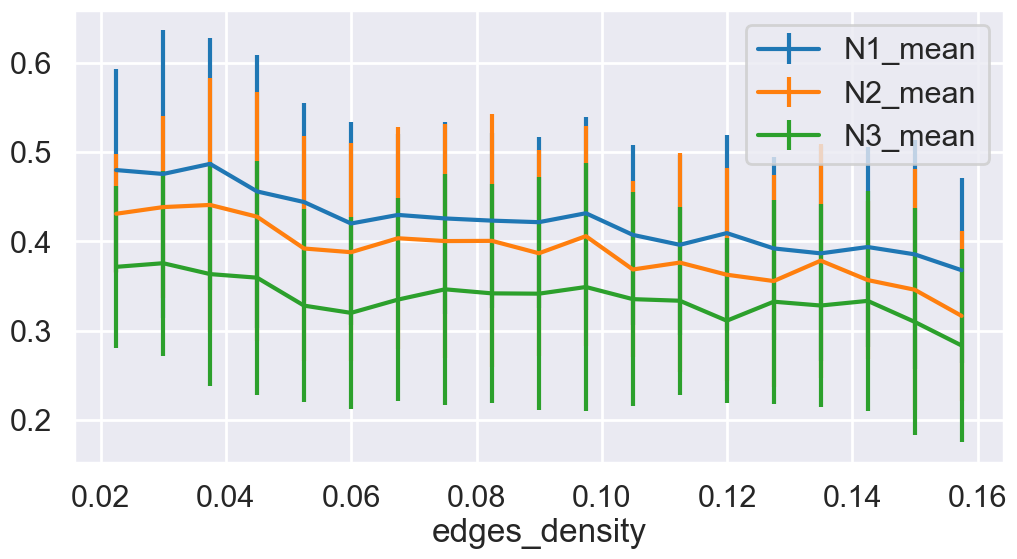

In [114]:
ax = df_barrido.plot("edges_density","N1_mean",yerr="N1_std",style='^-')
df_barrido.plot("edges_density","N2_mean",yerr="N2_std",ax=ax,style='^-')
df_barrido.plot("edges_density","N3_mean",yerr="N3_std",ax=ax,style='^-')

(-0.2, 1.1)

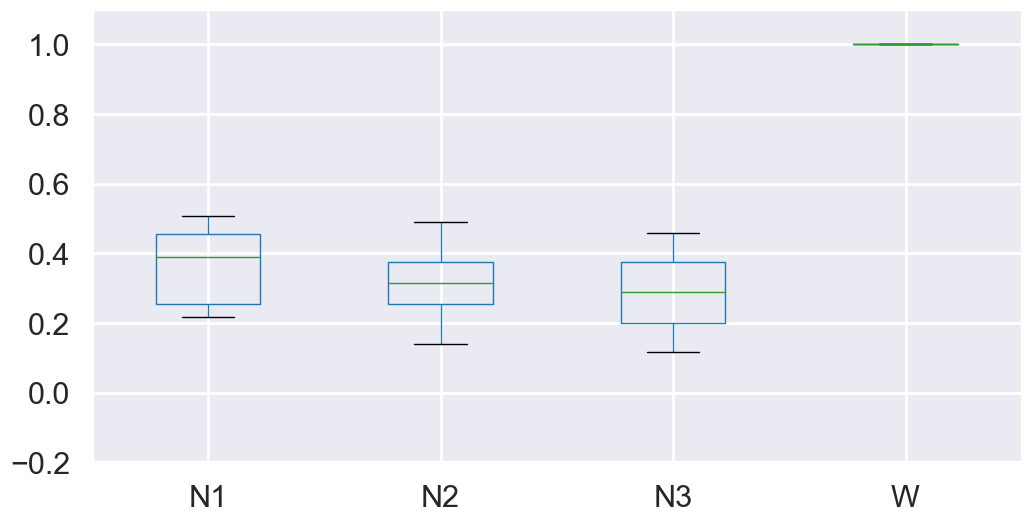

In [115]:
df_real.boxplot()
plt.ylim([-.2,1.1])

(-0.2, 1.1)

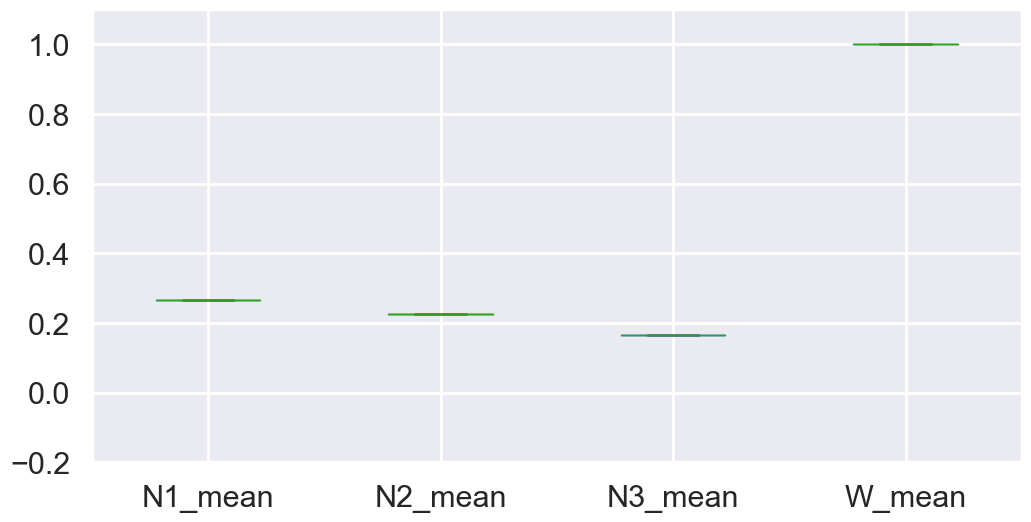

In [128]:
df_rand_real.boxplot(["N1_mean","N2_mean","N3_mean","W_mean"],)
plt.ylim([-.2,1.1])

['N1', 'N2', 'N3', 'W']
[0.26660827 0.22536339 0.16656197 1.        ]
[0.16566276 0.18099187 0.14238573 0.        ]


(-0.2, 1.1)

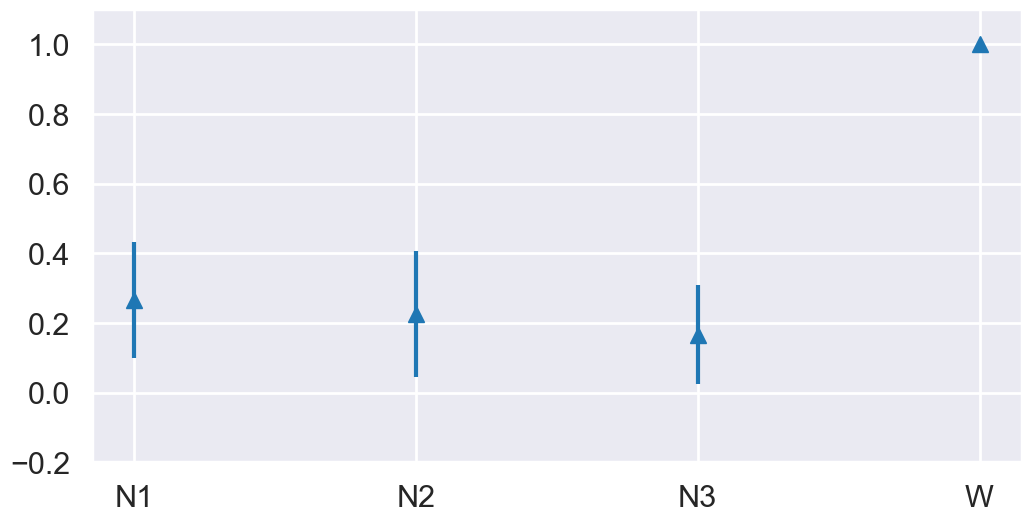

In [151]:
x = ["N1","N2","N3","W"]
y = df_rand_real[["N1_mean","N2_mean","N3_mean","W_mean"]].to_numpy()[0]
e = df_rand_real[["N1_std","N2_std","N3_std","W_std"]].to_numpy()[0]

print(x)
print(y)
print(e)

plt.errorbar(x, y, e, linestyle='None', marker='^')
plt.ylim([-.2,1.1])

In [91]:
values_per_rand = np.random.permutation(values_per_dict[filename_Nx])

In [198]:
np.random.uniform(0,1)

0.44360251287092667

In [199]:
def randomize_labels(a):
    #print(a)
    a = np.array(a)
    s = np.random.uniform(0,1,len(a))
    s = s>=np.random.uniform(0,1)#0.7
#     print(s)
    #s
#     print(a)
    c = a[s]
#     print(c)
    np.random.shuffle(c)
    a[s] = c
    return(a) 

In [200]:
random.seed(938413)

Np = 1000

Rand_perm = {"N1_mean":[],
             "N2_mean":[],
             "N3_mean":[],
             "W_mean":[],
             "N1_std":[],
             "N2_std":[],
             "N3_std":[],
             "W_std":[],
             }

tipo_red="W"
sleep_states = ['N1','N2','N3']

path = r'../resources/DataSujetos' # use your path
all_files = glob.glob(path + f"/{tipo_red}_suj*.csv")

for k in range(Np):

    lists_rand = {}
    for sleep_state in sleep_states:
        lists_rand[sleep_state] = []
    lists_rand["W"] = []


    for filename_W in all_files:
        values_obs = values_obs_dict[filename_W]

#         values_obs_rand = np.random.permutation(values_obs_dict[filename_W])
        values_obs_rand = randomize_labels(values_per_dict[filename_Nx])
#         values_obs_rand = list(np.random.randint(low = 0,high=4,size=len(values_obs)))
        rand_score = adjusted_rand_score(values_obs, values_obs_rand)
        lists_rand["W"].append(rand_score)

        for sleep_state in sleep_states:
            filename_Nx = filename_W.replace("W_", sleep_state+"_")
#             values_per_rand = np.random.permutation(values_per_dict[filename_Nx])
            values_per_rand = randomize_labels(values_per_dict[filename_Nx])
#             values_per_rand = list(np.random.randint(low = 0,high=4,size=len(values_obs)))
            rand_score = adjusted_rand_score(values_obs, values_per_rand)
            lists_rand[sleep_state].append(rand_score)
        #break
    df_rand = pd.DataFrame(lists_rand)
    df_rand_desc = df_rand.describe()
    
    Rand_perm["N1_mean"].append(df_rand_desc['N1']['mean'])
    Rand_perm["N2_mean"].append(df_rand_desc['N2']['mean'])
    Rand_perm["N3_mean"].append(df_rand_desc['N3']['mean'])
    Rand_perm["W_mean"].append(df_rand_desc['W']['mean'])
    Rand_perm["N1_std"].append(df_rand_desc['N1']['std'])
    Rand_perm["N2_std"].append(df_rand_desc['N2']['std'])
    Rand_perm["N3_std"].append(df_rand_desc['N3']['std'])
    Rand_perm["W_std"].append(df_rand_desc['W']['std'])

In [201]:
df_rand_perm = pd.DataFrame(Rand_perm)
df_rand_perm

,N1_mean,N2_mean,N3_mean,W_mean,N1_std,N2_std,N3_std,W_std
0,0.094352,0.107651,0.114764,0.071718,0.106692,0.091537,0.099430,0.109509
1,0.106228,0.094851,0.123181,0.090693,0.115845,0.125838,0.112157,0.081699
2,0.122466,0.100903,0.074449,0.094709,0.092829,0.098715,0.087428,0.083293
3,0.139623,0.081521,0.160472,0.080903,0.136538,0.082750,0.112584,0.097909
4,0.100463,0.103099,0.089067,0.112475,0.108214,0.131561,0.107459,0.111004
...,...,...,...,...,...,...,...,...
995,0.120662,0.109903,0.118079,0.055568,0.088482,0.093767,0.113075,0.070503
996,0.169791,0.101050,0.131909,0.110367,0.121644,0.112700,0.130528,0.107354
997,0.102591,0.093024,0.126201,0.090178,0.132449,0.099337,0.106798,0.090330
998,0.117611,0.108354,0.077327,0.099509,0.128084,0.117620,0.060365,0.078957


(-0.2, 1.1)

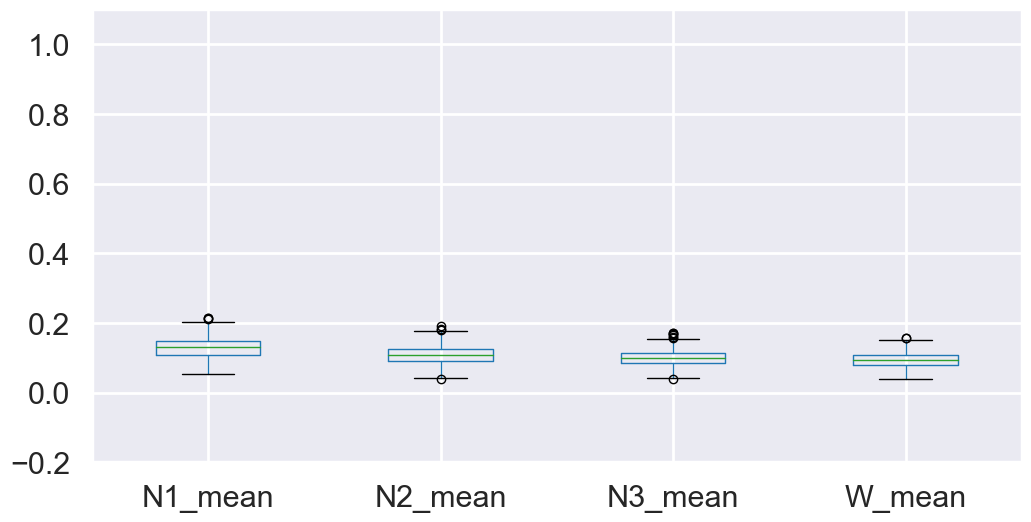

In [202]:
df_rand_perm.boxplot(["N1_mean","N2_mean","N3_mean","W_mean"])
plt.ylim([-.2,1.1])

In [231]:
df_barrido

,edges_density,N1_mean,N2_mean,N3_mean,W_mean,N1_std,N2_std,N3_std,W_std
0,0.022489,0.480788,0.431518,0.375238,1.0,0.116142,0.070427,0.110468,0.0
1,0.029985,0.476978,0.432714,0.375087,1.0,0.159985,0.096944,0.099467,0.0
2,0.037481,0.478329,0.443287,0.372474,1.0,0.141325,0.142552,0.128557,0.0
3,0.044978,0.467902,0.427362,0.360169,1.0,0.140230,0.139521,0.132247,0.0
4,0.052474,0.437320,0.400851,0.327009,1.0,0.113972,0.127622,0.107792,0.0
5,0.059970,0.411990,0.381664,0.326321,1.0,0.111020,0.114596,0.101518,0.0
6,0.067466,0.419856,0.399068,0.348013,1.0,0.097834,0.121356,0.127676,0.0
7,0.074963,0.436632,0.405462,0.352018,1.0,0.098858,0.135104,0.126938,0.0
8,0.082459,0.413461,0.395112,0.341384,1.0,0.092646,0.139566,0.127592,0.0
9,0.089955,0.428455,0.406212,0.347362,1.0,0.111131,0.126938,0.138045,0.0


In [259]:
df_barrido.iloc[1]

edges_density    0.029985
N1_mean          0.476978
N2_mean          0.432714
N3_mean          0.375087
W_mean           1.000000
N1_std           0.159985
N2_std           0.096944
N3_std           0.099467
W_std            0.000000
N1_mean_sign    -1.000000
N1_mean_pval    -1.000000
Name: 1, dtype: float64

In [262]:
df_barrido["N1_mean_pval"] = -1
for index, row in df_barrido.iterrows():
    pval = sum(df_rand_perm["N1_mean"]>row["N1_mean"])/Np
    df_barrido.at[index,"N1_mean_pval"] = pval
df_barrido

,edges_density,N1_mean,N2_mean,N3_mean,W_mean,N1_std,N2_std,N3_std,W_std,N1_mean_sign,N1_mean_pval
0,0.022489,0.480788,0.431518,0.375238,1.0,0.116142,0.070427,0.110468,0.0,-1,0
1,0.029985,0.476978,0.432714,0.375087,1.0,0.159985,0.096944,0.099467,0.0,-1,0
2,0.037481,0.478329,0.443287,0.372474,1.0,0.141325,0.142552,0.128557,0.0,-1,0
3,0.044978,0.467902,0.427362,0.360169,1.0,0.140230,0.139521,0.132247,0.0,-1,0
4,0.052474,0.437320,0.400851,0.327009,1.0,0.113972,0.127622,0.107792,0.0,-1,0
5,0.059970,0.411990,0.381664,0.326321,1.0,0.111020,0.114596,0.101518,0.0,-1,0
6,0.067466,0.419856,0.399068,0.348013,1.0,0.097834,0.121356,0.127676,0.0,-1,0
7,0.074963,0.436632,0.405462,0.352018,1.0,0.098858,0.135104,0.126938,0.0,-1,0
8,0.082459,0.413461,0.395112,0.341384,1.0,0.092646,0.139566,0.127592,0.0,-1,0
9,0.089955,0.428455,0.406212,0.347362,1.0,0.111131,0.126938,0.138045,0.0,-1,0


In [263]:
df_barrido["N2_mean_pval"] = -1
for index, row in df_barrido.iterrows():
    pval = sum(df_rand_perm["N2_mean"]>row["N2_mean"])/Np
    df_barrido.at[index,"N2_mean_pval"] = pval
df_barrido

,edges_density,N1_mean,N2_mean,N3_mean,W_mean,N1_std,N2_std,N3_std,W_std,N1_mean_sign,N1_mean_pval,N2_mean_pval
0,0.022489,0.480788,0.431518,0.375238,1.0,0.116142,0.070427,0.110468,0.0,-1,0,0
1,0.029985,0.476978,0.432714,0.375087,1.0,0.159985,0.096944,0.099467,0.0,-1,0,0
2,0.037481,0.478329,0.443287,0.372474,1.0,0.141325,0.142552,0.128557,0.0,-1,0,0
3,0.044978,0.467902,0.427362,0.360169,1.0,0.140230,0.139521,0.132247,0.0,-1,0,0
4,0.052474,0.437320,0.400851,0.327009,1.0,0.113972,0.127622,0.107792,0.0,-1,0,0
5,0.059970,0.411990,0.381664,0.326321,1.0,0.111020,0.114596,0.101518,0.0,-1,0,0
6,0.067466,0.419856,0.399068,0.348013,1.0,0.097834,0.121356,0.127676,0.0,-1,0,0
7,0.074963,0.436632,0.405462,0.352018,1.0,0.098858,0.135104,0.126938,0.0,-1,0,0
8,0.082459,0.413461,0.395112,0.341384,1.0,0.092646,0.139566,0.127592,0.0,-1,0,0
9,0.089955,0.428455,0.406212,0.347362,1.0,0.111131,0.126938,0.138045,0.0,-1,0,0


In [264]:
df_barrido["N3_mean_pval"] = -1
for index, row in df_barrido.iterrows():
    pval = sum(df_rand_perm["N3_mean"]>row["N3_mean"])/Np
    df_barrido.at[index,"N3_mean_pval"] = pval
df_barrido

,edges_density,N1_mean,N2_mean,N3_mean,W_mean,N1_std,N2_std,N3_std,W_std,N1_mean_sign,N1_mean_pval,N2_mean_pval,N3_mean_pval
0,0.022489,0.480788,0.431518,0.375238,1.0,0.116142,0.070427,0.110468,0.0,-1,0,0,0
1,0.029985,0.476978,0.432714,0.375087,1.0,0.159985,0.096944,0.099467,0.0,-1,0,0,0
2,0.037481,0.478329,0.443287,0.372474,1.0,0.141325,0.142552,0.128557,0.0,-1,0,0,0
3,0.044978,0.467902,0.427362,0.360169,1.0,0.140230,0.139521,0.132247,0.0,-1,0,0,0
4,0.052474,0.437320,0.400851,0.327009,1.0,0.113972,0.127622,0.107792,0.0,-1,0,0,0
5,0.059970,0.411990,0.381664,0.326321,1.0,0.111020,0.114596,0.101518,0.0,-1,0,0,0
6,0.067466,0.419856,0.399068,0.348013,1.0,0.097834,0.121356,0.127676,0.0,-1,0,0,0
7,0.074963,0.436632,0.405462,0.352018,1.0,0.098858,0.135104,0.126938,0.0,-1,0,0,0
8,0.082459,0.413461,0.395112,0.341384,1.0,0.092646,0.139566,0.127592,0.0,-1,0,0,0
9,0.089955,0.428455,0.406212,0.347362,1.0,0.111131,0.126938,0.138045,0.0,-1,0,0,0


In [265]:
df_barrido["W_mean_pval"] = -1
for index, row in df_barrido.iterrows():
    pval = sum(df_rand_perm["W_mean"]>row["W_mean"])/Np
    df_barrido.at[index,"W_mean_pval"] = pval
df_barrido 

,edges_density,N1_mean,N2_mean,N3_mean,W_mean,N1_std,N2_std,N3_std,W_std,N1_mean_sign,N1_mean_pval,N2_mean_pval,N3_mean_pval,W_mean_pval
0,0.022489,0.480788,0.431518,0.375238,1.0,0.116142,0.070427,0.110468,0.0,-1,0,0,0,0
1,0.029985,0.476978,0.432714,0.375087,1.0,0.159985,0.096944,0.099467,0.0,-1,0,0,0,0
2,0.037481,0.478329,0.443287,0.372474,1.0,0.141325,0.142552,0.128557,0.0,-1,0,0,0,0
3,0.044978,0.467902,0.427362,0.360169,1.0,0.140230,0.139521,0.132247,0.0,-1,0,0,0,0
4,0.052474,0.437320,0.400851,0.327009,1.0,0.113972,0.127622,0.107792,0.0,-1,0,0,0,0
5,0.059970,0.411990,0.381664,0.326321,1.0,0.111020,0.114596,0.101518,0.0,-1,0,0,0,0
6,0.067466,0.419856,0.399068,0.348013,1.0,0.097834,0.121356,0.127676,0.0,-1,0,0,0,0
7,0.074963,0.436632,0.405462,0.352018,1.0,0.098858,0.135104,0.126938,0.0,-1,0,0,0,0
8,0.082459,0.413461,0.395112,0.341384,1.0,0.092646,0.139566,0.127592,0.0,-1,0,0,0,0
9,0.089955,0.428455,0.406212,0.347362,1.0,0.111131,0.126938,0.138045,0.0,-1,0,0,0,0


In [266]:
f'Este permutation test da un p-valor << {1/Np} para todas las hipótesis.'

'Este permutation test da un p-valor << 0.001 para todas las hipótesis.'

Esto implica que el agrupamiento que se hace en el estado Nx es distinto al agrupamiento que se hace en W, y es significativamente distinto a una asignación aleatoria de etiquetas a los nodos.